This notebook gives some examples of the Widely Applicable Information Criterion (WAIC) and its use with STAN.


The three cases considered are:
<ol>
<li>Linear Model vs Generalized Linear Model</li>
<li>Linear model feature selection </li>
<li>AR order determination </li>
</ol>

In [1]:
# this section imports stuff 
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
from pystan import StanModel
import arviz as az
from platform import python_version
import matplotlib.pyplot as plt
from orbit.utils.simulation import make_regression

In [2]:
%matplotlib inline

In [3]:
# check the things!
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pystan: {}'.format(pystan.__version__))
print(python_version())

pandas: 1.3.1
numpy: 1.21.1
pystan: 2.19.1.1
3.7.8


This section gives the WAIC function. For it to work the models must have a log probability of each observation for each sample. 

Note that the penalty term (k) is currently left as an argument to the user. In "Understanding predictive information criteria for Bayesian models” and "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC" k=2 is assumed. As is discussed here k = log(n) mighte be another choice. Note this is not WBIC which is its own thing. 



In [4]:
#WAIC
def WAIC(log_p, k = 2 ):
    P_WAIC2 = np.nansum(log_p.var(axis=0)) # the effective number of paramters 
    lppd = np.nansum(np.log(np.exp(log_p).mean(axis=0))) # the sum of log pointwise predictive density
    WAIC = -2*lppd +k* P_WAIC2 
    return WAIC, lppd, P_WAIC2

## First example:
This example considers the fitting of linear model with both a normal and a  Generalized normal distribution 

In [5]:
# make data 
n = 1000
x0 = np.ones(n)
x1 = np.random.normal(0, 10, n)
x2 = np.random.normal(0, 0.5, n)

X = np.vstack([x0, x1, x2]).transpose()


coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(1000, 3)
(1000,)
[2.6 0.2 0.1]


Four parts to a STAN process. Data, Model, Fitting, and outputs

In [6]:
# data
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [7]:
%%time
# make model 1 
model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] beta;
      real<lower=0> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      yhat = X * beta;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      y ~ normal(yhat, sigma);
    }
    
"""
sm_simple = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_412e1436f24115a7272534d9976f78f6 NOW.


CPU times: user 999 ms, sys: 80.8 ms, total: 1.08 s
Wall time: 46.6 s


In [8]:
%%time
# make model 2 
model_code = """
    functions{
    real gen_norm_lpdf(real x, real alpha, real beta, real mu){
        return(log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(x-mu)/alpha, beta) );        
        }
    }


    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    

    
    parameters{
      vector[n_features] m;
      real<lower=0> alpha;
      real<lower=0,upper=5> beta;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      yhat = X * m;
      for (i in 1:n_obs)
          log_p[i] = log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(y[i]-yhat[i])/alpha, beta);
    }
    
    model {
      //vector[n_obs] yhat;
      //yhat = X * m;
      alpha ~ uniform(0, 10);
      beta ~ uniform(0, 5);
      
      for (i in 1:n_obs)
          target += gen_norm_lpdf(y[i]| alpha, beta, yhat[i] );
      //y ~ normal(yhat, alpha);
    }
    
"""
sm_complex = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b4b8122407a34d7b8cd18507d807e8a2 NOW.


CPU times: user 1.04 s, sys: 67.5 ms, total: 1.1 s
Wall time: 45.4 s


In [9]:
%%time
# fit the models 
fit_simple = sm_simple.sampling(data=data, iter=10000, chains=4, verbose =True)
fit_complex = sm_complex.sampling(data=data, iter=10000, chains=4, verbose =True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 1.37 s, sys: 13.8 s, total: 15.2 s
Wall time: 1min 13s


In [10]:
# extract the posteriors
posteriors_simple = fit_simple.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_simple.keys())

posteriors_complex = fit_complex.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_complex.keys())

odict_keys(['beta', 'sigma', 'yhat', 'log_p', 'lp__'])
odict_keys(['m', 'alpha', 'beta', 'yhat', 'log_p', 'lp__'])


In [11]:
WAIC_s, lppd_s, P_WAIC2_s = WAIC(log_p = posteriors_simple['log_p'])
WAIC_c, lppd_c, P_WAIC2_c = WAIC(log_p = posteriors_complex['log_p'])

print("WAIC")
print(WAIC_s)
print(WAIC_c)

print("Effective # Pars")
print(P_WAIC2_s)
print(P_WAIC2_c)

print("log pointwise predictive density")
print(lppd_s)
print(lppd_c)

WAIC
2700.098437558937
2695.2999768508926
Effective # Pars
3.6321420914698623
4.771916602933693
log pointwise predictive density
-1346.4170766879986
-1342.8780718225125


The above should show that simple model is about 2 points better than the complex. The complex has one more parameter and should have about the same LPPD.

## Example 2
Feature selection for linear models with WAIC.

In [12]:
# make data 
n = 1000
x0 = np.ones(n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X9 = np.vstack([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]).transpose()
X = np.vstack([x0, x1, x2]).transpose()
coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(1000, 3)
(1000,)
[2.6 0.2 0.1]


In [13]:
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [14]:
%%time
model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] beta;
      real<lower=0> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      yhat = X * beta;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      y ~ normal(yhat, sigma);
    }
    
"""
sm_temp = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_412e1436f24115a7272534d9976f78f6 NOW.


CPU times: user 1.04 s, sys: 81.5 ms, total: 1.12 s
Wall time: 43.1 s


In [15]:
%%time
# this cell loops through models with different number of features
WAIC_list = np.zeros((10))
lppd_list = np.zeros((10))
p_list = np.zeros((10))

for i in range(1, 10):
    X = X9.copy()
    X = X[:,:i]
    print(X.shape[1])
    data = {
        'n_obs': len(y),
        'n_features': X.shape[1],
        'y': y,
        'X': X,
    }
    
    fit_temp = sm_temp.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_temp = fit_temp.extract(permuted=True)
    WAIC_v, lppd, P_WAIC2 = WAIC(log_p = posteriors_temp['log_p'])
    WAIC_list[i-1] = WAIC_v
    lppd_list[i-1] = lppd
    p_list[i-1] = P_WAIC2  
    
    print("-------------------------------------------------------------------------------")
    print(i)
    print(WAIC_v)
    print("-------------------------------------------------------------------------------")    

1


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2885.28134582768
-------------------------------------------------------------------------------
2


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2830.2655456835746
-------------------------------------------------------------------------------
3


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2815.4119267285287
-------------------------------------------------------------------------------
4


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2817.343076021675
-------------------------------------------------------------------------------
5


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2818.676322886171
-------------------------------------------------------------------------------
6


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2820.367725844212
-------------------------------------------------------------------------------
7


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2822.302334001832
-------------------------------------------------------------------------------
8


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2823.910048379475
-------------------------------------------------------------------------------
9


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2825.5917704362637
-------------------------------------------------------------------------------
CPU times: user 2.33 s, sys: 3.24 s, total: 5.57 s
Wall time: 17.6 s


In [16]:
print(WAIC_list)
print( lppd_list)
print( p_list)

[2885.28134583 2830.26554568 2815.41192673 2817.34307602 2818.67632289
 2820.36772584 2822.302334   2823.91004838 2825.59177044    0.        ]
[-1440.66767558 -1412.10939141 -1403.79047009 -1403.72266223
 -1403.53045153 -1403.25759589 -1403.20611636 -1403.28473916
 -1403.32124835     0.        ]
[1.97299734 3.02338144 3.91549327 4.94887578 5.80770991 6.92626704
 7.94505064 8.67028503 9.47463687 0.        ]


The min WAIC should be for the 3rd itteration

## Example 3
AR order selections

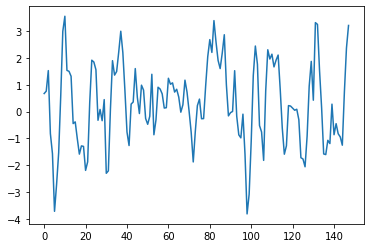

In [17]:
# make the data
n = 1000
eta = np.random.normal(0, 1, n)
rho = [0.85, -0.25]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + eta[i]

#plt.plot(y)
plt.plot(y[2:150])

In [18]:
data = {
    'N': len(y),
    'K': 3,
    'y': y,
}

In [19]:
%%time
model_code = """
    data {
      int<lower=0> K;
      int<lower=0> N;
      real y[N];
    }
    parameters {
      real<lower=-1,upper=1> rho[K];
      real sigma;
    }
    
    
    transformed parameters {
        vector[N] yhat;
        vector[N] log_p;
        for (i in (K+1):N) {
            yhat[i] = 0;
            for (k in 1:K)
              yhat[i] += rho[k] * y[i-k];
            log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
            }
    }
    
    
    model {
      
      for (i in (K+1):N) 
        y[i] ~ normal(yhat[i], sigma);
      
    }"""
AR_K = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_803ebb3b05161220dab6fc73b7ece80b NOW.


CPU times: user 1.06 s, sys: 71.5 ms, total: 1.13 s
Wall time: 40.5 s


In [20]:
%%time
WAIC_list = np.zeros((10))
lppd_list = np.zeros((10))
p_list = np.zeros((10))

for k in range(1, 11):
    data = {
    'N': len(y),
    'K': k,
    'y': y,
    }
    fit_AR_K = AR_K.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_AR_K = fit_AR_K.extract(permuted=True) 
    WAIC_v, lppd, P_WAIC2 = WAIC(log_p = posteriors_AR_K['log_p'])
    WAIC_list[k-1] = WAIC_v
    lppd_list[k-1] = lppd
    p_list[k-1] = P_WAIC2  
    
    print("-------------------------------------------------------------------------------")
    print(k)
    print(WAIC_v)
    print("-------------------------------------------------------------------------------")    
    

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2925.008571937309
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2851.1061909207306
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2849.920120129771
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2849.6814793893413
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2847.2520567853953
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2839.8743094134584
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2839.7751940220946
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2833.9483947898693
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2834.0645427391355
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
10
2833.8045820931243
-------------------------------------------------------------------------------
CPU times: user 2.69 s, sys: 4.09 s, total: 6.78 s
Wall time: 1min 16s


In [21]:
print(WAIC_list)
print(lppd_list)
print(p_list)

[2925.00857194 2851.10619092 2849.92012013 2849.68147939 2847.25205679
 2839.87430941 2839.77519402 2833.94839479 2834.06454274 2833.80458209]
[-1460.60913072 -1422.50875992 -1420.79105562 -1419.6806621
 -1417.60881407 -1412.88950087 -1411.79082942 -1407.87885243
 -1406.86988313 -1405.68371009]
[ 1.89515525  3.04433554  4.16900444  5.16007759  6.01721432  7.04765383
  8.09676759  9.09534496 10.16238824 11.21858096]



This does not seem to work because there is too much data and the AR lag parameters are too efficient
 

In [22]:
WAIC_list = np.zeros((10))
lppd_list = np.zeros((10))
p_list = np.zeros((10))

for k in range(1, 11):
    data = {
    'N': len(y),
    'K': k,
    'y': y,
    }
    fit_AR_K = AR_K.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_AR_K = fit_AR_K.extract(permuted=True) 
    ####################################################################################
    WAIC_v, lppd, P_WAIC2 = WAIC(log_p = posteriors_AR_K['log_p'], k = np.log(n-10)) # this line was updated
    # log 990 is number of data points shared by all models. THis is similar to the BIC.
    ####################################################################################    
    WAIC_list[k-1] = WAIC_v
    lppd_list[k-1] = lppd
    p_list[k-1] = P_WAIC2  
    
    print("-------------------------------------------------------------------------------")
    print(k)
    print(WAIC_v)
    print("-------------------------------------------------------------------------------")    

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2934.54483254403
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2865.494407348225
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2869.9964534070286
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2876.252874585508
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2877.260879301775
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2873.4249990816747
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2879.701569467063
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2877.7365992067657
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2883.801708281401
-------------------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
10
2888.6073158823397
-------------------------------------------------------------------------------


In [23]:
print(WAIC_list)
print( lppd_list)
print( p_list)

[2934.54483254 2865.49440735 2869.99645341 2876.25287459 2877.2608793
 2873.42499908 2879.70156947 2877.73659921 2883.80170828 2888.60731588]
[-1460.6064328  -1422.50581582 -1420.79328927 -1419.68483765
 -1417.61648539 -1412.88064911 -1411.78323226 -1407.87287947
 -1406.88232172 -1405.69879897]
[ 1.93281201  2.96950593  4.11874313  5.34716976  6.09302788  6.91008114
  8.13822937  8.98716903 10.15367654 11.19353736]


The above should show that the 2nd iteration is best 